In [ ]:
# ============================================================
# FMLCourse — Fundamentals of Machine Learning
# ------------------------------------------------------------
# Lecture: Introduction to MNIST Dataset and CNN
# Author : Burak Demirel
# Title  : MRI Clinical Scientist, Philips Healthcare
# ------------------------------------------------------------
# ============================================================


import torch, math
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import numpy as np


import torch.nn.functional as F

# let's load the MNIST dataset

data_full = datasets.MNIST(
    root = 'data',
    train = 'true',
    transform = ToTensor(),
    download = True,
    )


In [2]:
# train, test and validation seperation, 80-10-10 split
# MNIST has 60k images, known number
train_data, test_data, valid_data = torch.utils.data.random_split(data_full, [48000, 6000, 6000])


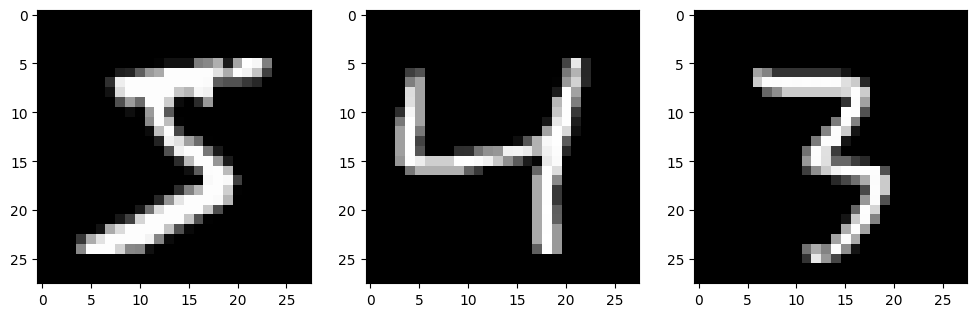

In [3]:
#how to visualize the data
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(data_full.data[0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(data_full.data[2], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(data_full.data[44], cmap='gray')

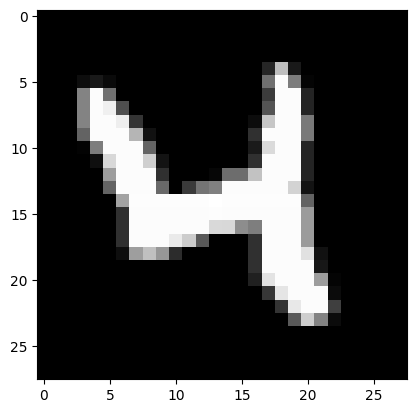

In [4]:
# access the data but you need export it first
data1 = data_full.data[20]
plt.imshow(data1, cmap='gray')


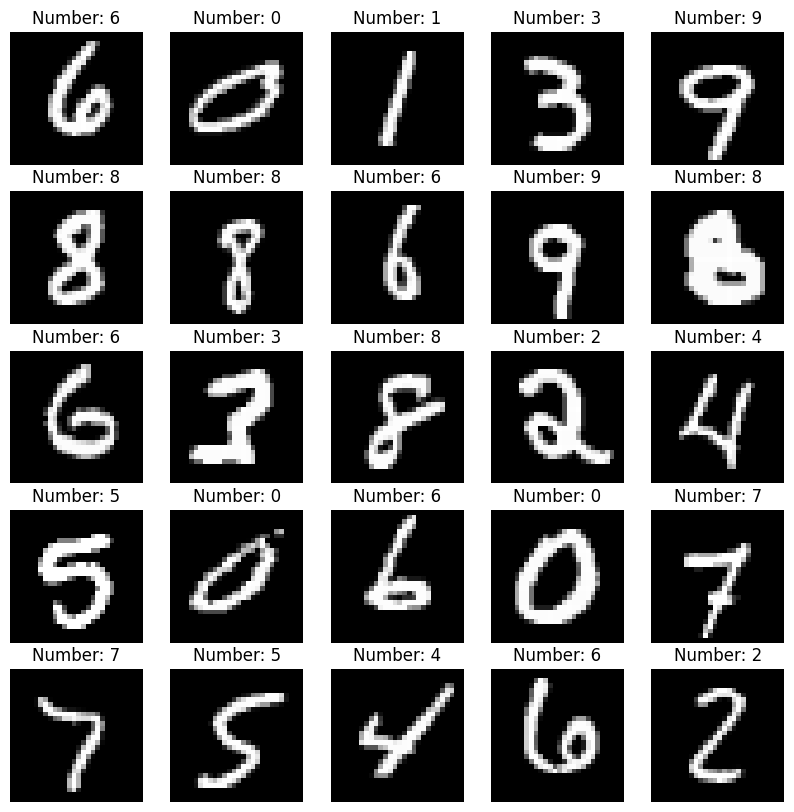

In [5]:
# how to visualize multiple images

figure = plt.figure(figsize=(10,10))
cols, row = 5,5

for i in range(1, cols*row+1):
    
    idx = torch.randint(len(data_full), size=(1,)).item()
    
    img, label = data_full[idx]
    
    figure.add_subplot(row,cols,i)
    plt.title('Number: ' + str(label))
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [6]:
# let's put into a dict 
batch_size = 100

loaders = {'train': torch.utils.data.DataLoader(train_data,
                                                batch_size =batch_size,
                                                shuffle = True),
           
           'test': torch.utils.data.DataLoader(test_data,
                                               batch_size =batch_size,
                                               shuffle = True),
           'valid': torch.utils.data.DataLoader(valid_data,
                                               batch_size =batch_size,
                                               shuffle = True),
           
           }

# example
#for images, labels in train_loader:
    # each 'images' is a tensor of shape [100, 1, 28, 28]
    # each 'labels' is a tensor of shape [100]

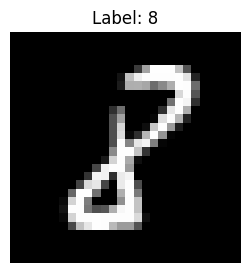

In [7]:
# Get one batch from the training loader
train_loader = loaders['train']

# Access the underlying dataset
dataset = train_loader.dataset

# Pick a sample
image, label = dataset[1]

# Plot
plt.figure(figsize=(3,3))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}", fontsize=12)
plt.axis('off')
plt.show()


In [8]:
image.shape

torch.Size([1, 28, 28])

In [9]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    """
    LeNet — one of the first convolutional neural networks (CNNs).
    It takes a 28×28 grayscale image (like an MNIST digit)
    and classifies it into one of 10 classes (digits 0–9).
    """

    def __init__(self):
        super(LeNet, self).__init__()

        # === Convolutional Layers ===
        # 1 input channel (grayscale), 6 output feature maps, 5×5 filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()          # activation: introduces nonlinearity
        self.pool1 = nn.MaxPool2d(2)    # reduces spatial size by 2×2 pooling

        # Second convolutional block
        # Takes 6 feature maps and produces 16 new ones
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # === Fully Connected Layers ===
        # After the two conv+pool layers, the image is reduced to size 16×4×4 = 256 features
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()

        # Output layer: 10 neurons → one for each digit 0–9
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        Defines how data flows through the network from input to output.
        """
        # ---- Convolution Block 1 ----
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # ---- Convolution Block 2 ----
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # ---- Flatten ----
        # Convert from 4D tensor [batch, channels, height, width] → 2D [batch, features]
        x = x.view(x.size(0), -1)

        # ---- Fully Connected Layers ----
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        # ---- Output Layer ----
        x = self.fc3(x)  # raw scores for 10 digits (no activation here)
        return x


In [10]:
# setting up the model    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("mps") # for mac m series

# -----------------------------
# 1) Create the model and move it to the device
# -----------------------------
model = LeNet()              # or your alternative models
model.to(device)

# -----------------------------
# 2) Define loss function
#    CrossEntropyLoss = good default for multi-class classification (10 digits)
# -----------------------------
criterion = nn.CrossEntropyLoss()
# torch already has the softmax in the loss function here! this is the reason why it is not added in the model

# -----------------------------
# 3) Define optimizer
#    SGD with your specified learning rate.
#    (Tip: momentum=0.9 is common, but we keep your exact setup.)
# -----------------------------
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# -----------------------------
# 5) Training configuration
# -----------------------------
num_epochs = 10  # number of passes over the dataset

# -----------------------------
# 6) For logging/plotting loss later
# -----------------------------
loss_list = []       # store per-batch losses, if you wish
loss_list_mean = []  # store per-epoch mean losses


In [ ]:
#if you want to use ResNet18 instead of LeNet
# --- IGNORE ---
from torchvision import models


from torchvision import models
import torch.nn as nn

def resnet18_mnist(num_classes=10):
    # No pretrained weights
    model = models.resnet18(weights=None)
    # Adapt to 1-channel, small images: 3×3 conv, stride=1, no maxpool
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    # Final classifier for 10 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ---- usage ----
model = resnet18_mnist(num_classes=10).to(device)


RuntimeError: The expanded size of the tensor (3) must match the existing size (7) at non-singleton dimension 3.  Target sizes: [64, 1, 3, 3].  Tensor sizes: [64, 1, 7, 7]

Epoch 1/10
  Train Loss: 0.8364 | Val Loss: 0.1633 | Val Acc: 95.10%
Epoch 2/10
  Train Loss: 0.1272 | Val Loss: 0.1154 | Val Acc: 96.52%
Epoch 3/10
  Train Loss: 0.0864 | Val Loss: 0.0791 | Val Acc: 97.73%
Epoch 4/10
  Train Loss: 0.0669 | Val Loss: 0.0804 | Val Acc: 97.58%
Epoch 5/10
  Train Loss: 0.0546 | Val Loss: 0.0686 | Val Acc: 97.97%
Epoch 6/10
  Train Loss: 0.0481 | Val Loss: 0.0633 | Val Acc: 98.12%
Epoch 7/10
  Train Loss: 0.0398 | Val Loss: 0.0555 | Val Acc: 98.33%
Epoch 8/10
  Train Loss: 0.0347 | Val Loss: 0.0545 | Val Acc: 98.30%
Epoch 9/10
  Train Loss: 0.0303 | Val Loss: 0.0529 | Val Acc: 98.50%
Epoch 10/10
  Train Loss: 0.0267 | Val Loss: 0.0552 | Val Acc: 98.43%


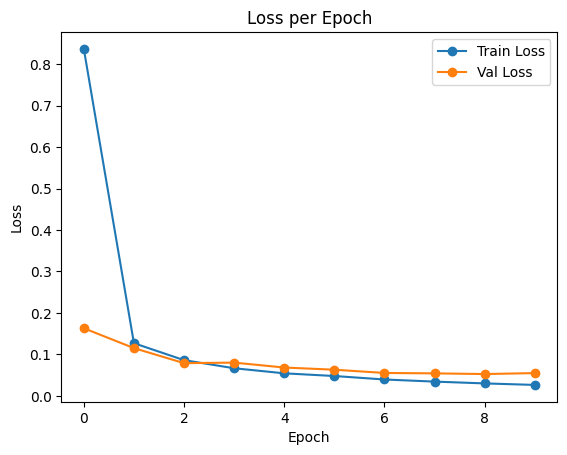

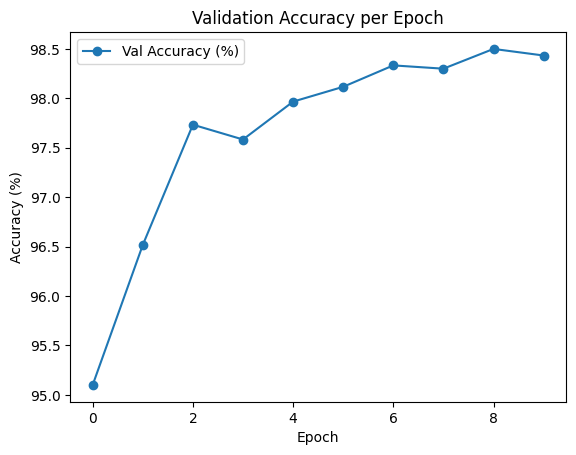

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Make sure your LeNet's last layer has NO ReLU.
# x = self.fc3(x)   # <-- raw logits

epoch_loss_list = []       # avg training loss per epoch
val_epoch_loss_list = []   # avg validation loss per epoch
val_epoch_acc_list = []    # validation accuracy per epoch (%)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # ----- TRAIN -----
    model.train()  # turn on training mode
    train_losses = []

    for images, labels in loaders['train']:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()              # 1) reset gradients
        outputs = model(images)            # 2) forward pass
        loss = criterion(outputs, labels)  # 3) compute loss
        loss.backward(); optimizer.step()  # 4) backprop + update

        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses))
    epoch_loss_list.append(train_loss)

    # ----- VALIDATION -----
    model.eval()   # turn off training-specific layers (e.g., dropout)
    val_losses = []
    correct, total = 0, 0

    with torch.no_grad():  # no grads needed for validation
        for vimgs, vlabels in loaders['valid']:
            vimgs, vlabels = vimgs.to(device), vlabels.to(device)
            vouts = model(vimgs)
            vloss = criterion(vouts, vlabels)
            val_losses.append(vloss.item())

            _, preds = torch.max(vouts, dim=1)
            # returns the max value and the location which is the digit for us
            total += vlabels.size(0)
            correct += (preds == vlabels).sum().item()

    val_loss = float(np.mean(val_losses))
    val_acc = 100.0 * correct / total if total else 0.0
    val_epoch_loss_list.append(val_loss)
    val_epoch_acc_list.append(val_acc)

    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ----- PLOTS -----
plt.figure()
plt.plot(epoch_loss_list, marker='o', label='Train Loss')
plt.plot(val_epoch_loss_list, marker='o', label='Val Loss')
plt.title('Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure()
plt.plot(val_epoch_acc_list, marker='o', label='Val Accuracy (%)')
plt.title('Validation Accuracy per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.show()


In [12]:
## TEST PART#############

#Accuracy
correct = 0
total = 0

for images,labels in loaders['test']:
    
    images = images.requires_grad_().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    
    # get the predictions from the maximum value
    _,predicted = torch.max(outputs.data, 1)
    
    # how many labels I have, also mean the size of the valid
    total += labels.size(0)
    
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

print('Test Accuracy: {}'.format(accuracy))
################################

Test Accuracy: 98.76666259765625


In [13]:
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageDraw, ImageOps
import torch
import torch.nn.functional as F
import numpy as np

def launch_digit_gui(model, device, img_size=28, stroke_width=18):
    """
    Launches a Tkinter GUI to draw a digit and classify it with a trained PyTorch model.
    Args:
        model: Trained PyTorch model that accepts [B,1,28,28] (MNIST-like).
        device: 'cuda' or 'cpu'
        img_size: target size for model input (default 28)
        stroke_width: thickness of the drawing brush on the canvas/PIL image
    """
    model.eval()
    model.to(device)

    # Canvas size (large for nicer drawing), we’ll downscale to 28x28
    CANVAS_W, CANVAS_H = 280, 280

    # Create a parallel PIL image to capture strokes with high fidelity
    pil_img = Image.new("L", (CANVAS_W, CANVAS_H), color=0)  # black background
    pil_draw = ImageDraw.Draw(pil_img)

    # Normalization (MNIST defaults). If you trained differently, edit here.
    USE_MNIST_NORM = True
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

    def preprocess_for_model(pil_gray):
        """
        Convert the canvas PIL image to a model-ready tensor: [1,1,28,28]
        """
        # Invert so strokes are white on black if needed (our canvas is white-on-black already)
        # Ensure high-contrast by auto-contrast
        proc = ImageOps.autocontrast(pil_gray)

        # Downscale to 28x28 using ANTIALIAS (LANCZOS)
        proc = proc.resize((img_size, img_size), Image.LANCZOS)

        # Convert to float tensor in [0,1]
        x = np.array(proc, dtype=np.float32) / 255.0  # shape [H,W]
        x = x[None, None, :, :]  # [1,1,H,W]

        if USE_MNIST_NORM:
            x = (x - MNIST_MEAN) / MNIST_STD

        t = torch.from_numpy(x).to(device)
        return t

    def predict_digit():
        with torch.no_grad():
            x = preprocess_for_model(pil_img)
            logits = model(x)
            probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()
            pred = int(np.argmax(probs))

        # Build a friendly message: top-3 probabilities
        top3_idx = np.argsort(-probs)[:3]
        top3_txt = "\n".join([f"{i}: {probs[i]*100:.1f}%" for i in top3_idx])
        result_var.set(f"Prediction: {pred}\n\nTop-3:\n{top3_txt}")

    def clear_canvas():
        canvas.delete("all")
        # Reset background to black
        canvas.create_rectangle(0, 0, CANVAS_W, CANVAS_H, fill="black", outline="black")
        pil_draw.rectangle([0, 0, CANVAS_W, CANVAS_H], fill=0)
        result_var.set("Draw a digit, then click Predict.")

    # Drawing handlers
    last_x, last_y = None, None

    def on_button_press(event):
        nonlocal last_x, last_y
        last_x, last_y = event.x, event.y
        # Draw a small dot
        r = stroke_width // 2
        canvas.create_oval(event.x - r, event.y - r, event.x + r, event.y + r, fill="white", outline="white")
        pil_draw.ellipse([event.x - r, event.y - r, event.x + r, event.y + r], fill=255)

    def on_move(event):
        nonlocal last_x, last_y
        if last_x is None or last_y is None:
            last_x, last_y = event.x, event.y
            return
        # Draw line segment on canvas
        canvas.create_line(last_x, last_y, event.x, event.y, width=stroke_width, fill="white", capstyle=tk.ROUND, smooth=True)
        # Mirror on PIL image
        pil_draw.line([last_x, last_y, event.x, event.y], fill=255, width=stroke_width, joint="curve")
        last_x, last_y = event.x, event.y

    def on_button_release(event):
        nonlocal last_x, last_y
        last_x, last_y = None, None

    # Build the window
    root = tk.Tk()
    root.title("Handwritten Digit Classifier")

    # Canvas with black background
    canvas = tk.Canvas(root, width=CANVAS_W, height=CANVAS_H, bg="black", highlightthickness=0)
    canvas.grid(row=0, column=0, columnspan=3, padx=10, pady=10)
    canvas.bind("<ButtonPress-1>", on_button_press)
    canvas.bind("<B1-Motion>", on_move)
    canvas.bind("<ButtonRelease-1>", on_button_release)

    # Controls
    predict_btn = tk.Button(root, text="Predict", command=predict_digit)
    predict_btn.grid(row=1, column=0, sticky="ew", padx=10, pady=5)

    clear_btn = tk.Button(root, text="Clear", command=clear_canvas)
    clear_btn.grid(row=1, column=1, sticky="ew", padx=10, pady=5)

    quit_btn = tk.Button(root, text="Quit", command=root.destroy)
    quit_btn.grid(row=1, column=2, sticky="ew", padx=10, pady=5)

    # Result label
    result_var = tk.StringVar(value="Draw a digit, then click Predict.")
    result_lbl = tk.Label(root, textvariable=result_var, justify="left", font=("Segoe UI", 11))
    result_lbl.grid(row=2, column=0, columnspan=3, padx=10, pady=(0,10), sticky="w")

    # Start with a clean canvas
    clear_canvas()
    root.mainloop()

# --- Usage example (after training) ---
# model is your trained CNN; device is the same device you used to train
# launch_digit_gui(model, device)


In [14]:
launch_digit_gui(model, device)

In [10]:
# ============================================================
# PROJECT OVERVIEW — Denoising MNIST with a Simple U-Net
# ============================================================

# 1️ We use the MNIST dataset.
#     - MNIST images are 28×28 grayscale digits (0–9).
#     - Normally used for classification, but here we treat them
#       as small “images” to test a denoising U-Net model.

# 2 We resize (interpolate) each image to 128×128.
#     - The original 28×28 is too small for U-Net because
#       U-Nets downsample and upsample several times (by factors of 2).
#       If we kept 28×28, the image would become too tiny after pooling.
#     - Resizing to 128×128 makes it large enough for 3–4
#       downsampling/upsampling stages.
#     - So yes — upsampling to 128×128 *makes sense* for demonstration,
#       though we’re not gaining new detail, just making it compatible
#       with the network’s structure.

# 3 The model is a **basic U-Net**.
#     - It learns to map a noisy image to a clean version.
#     - The "down path" captures context (what the image is).
#     - The "up path" restores detail (where things are).

# 4 Before feeding images into the model, we **add noise**.
#     - For example, Gaussian noise: noisy = clean + 0.1 * randn(...)
#     - The goal is for the network to learn how to *remove* noise
#       and reconstruct the original clean image.

# 5 The model outputs the *denoised* image.
#     - During training, we compare this output with the original
#       clean image — pixel by pixel.
#     - Over many examples, the model learns to produce clean outputs.

# 6 Loss function: L2 norm = MSE (Mean Squared Error).
#     - "L2 loss" means:  loss = mean((output - target)^2)
#     - It measures how close each pixel in the prediction is to
#       the true (clean) pixel value.
#     - In PyTorch, we can use `nn.MSELoss()` or compute it manually.
# ============================================================


In [58]:
import torch
import torch.nn as nn

# ---- Small building block: "DoubleConv" ----
# Imagine two quick "look-and-learn" passes over the picture.
# Each pass looks at small 3x3 patches and learns patterns.
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),  # learn patterns
            nn.ReLU(inplace=True),                               # keep only positive signals
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), # learn richer patterns
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

# ---- Simple U-Net ----
# Big picture:
# 1) Go DOWN: shrink the image step-by-step to understand the big context.
# 2) Go UP: enlarge it back, using "bridges" to recover fine details.
# 3) Output: make a final prediction map (e.g., which pixels are "object" vs "background").
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_ch=32):
        """
        in_channels:  number of channels in the input image (1 for grayscale, 3 for color)
        out_channels: number of prediction maps you want (1 for binary mask; N for N classes)
        base_ch:      how many features to learn at the first level (model size knob)
        """
        super().__init__()

        # ---- DOWN path (compress to understand context) ----
        self.step1 = DoubleConv(in_channels, base_ch)        # keep size the same
        self.pool1 = nn.MaxPool2d(2)                         # shrink H,W by 2

        self.step2 = DoubleConv(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)

        self.step3 = DoubleConv(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)

        # ---- MIDDLE (the most compressed representation) ----
        self.middle = DoubleConv(base_ch*4, base_ch*8)

        # ---- UP path (rebuild, using bridges for details) ----
        # upsample: make the image bigger by 2, then combine with the saved detail ("bridge")
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_ch*8, base_ch*4)   # (up path + bridge) -> refine

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_ch*4, base_ch*2)

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch,   kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_ch*2, base_ch)

        # ---- Final 1x1 "decision" layer ----
        self.out_head = nn.Conv2d(base_ch, out_channels, kernel_size=1)
        # (No activation here: use Sigmoid/Softmax outside depending on your loss)

    def forward(self, x):
        # ===== DOWN: remember features at each step (these are our "bridges") =====
        s1 = self.step1(x)              # detailed features (full size)
        s2 = self.step2(self.pool1(s1)) # smaller view with more abstract features
        s3 = self.step3(self.pool2(s2)) # even smaller, even more abstract

        # ===== MIDDLE =====
        m  = self.middle(self.pool3(s3))

        # ===== UP: grow back + bring details from the matching "bridge" =====
        x  = self.up3(m)
        x  = torch.cat([x, s3], dim=1)  # bridge: combine current with saved details
        x  = self.dec3(x)

        x  = self.up2(x)
        x  = torch.cat([x, s2], dim=1)
        x  = self.dec2(x)

        x  = self.up1(x)
        x  = torch.cat([x, s1], dim=1)
        x  = self.dec1(x)

        # Final pixel-wise prediction map
        return self.out_head(x)


In [59]:
from torch.utils.data import random_split, DataLoader

# Step 1: take a 2200-sample subset from the full 60,000
subset_data, _ = random_split(data_full, [2200, len(data_full) - 2200])

# Step 2: split that subset into train/valid/test = 2000 / 100 / 100
train_data, valid_data, test_data = random_split(subset_data, [2000, 100, 100])

# Step 3: make dataloaders
batch_size = 100
loaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_data, batch_size=batch_size, shuffle=False),
    'test':  DataLoader(test_data,  batch_size=batch_size, shuffle=False),
}



In [60]:
# ----- setup (swap the classifier to UNet + MSE) -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps')

model = SimpleUNet(in_channels=1, out_channels=1, base_ch=32).to(device)

# ---- loss & optimizer ----
criterion = nn.MSELoss()                     # L2/MSE for denoising
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # more stable than SGD@0.1
num_epochs = 10

epoch_loss_list = []
val_epoch_loss_list = []


In [61]:
from tqdm import tqdm
import torch, math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# ---- knobs ----
TARGET_HW = 64
FRAC_MIN, FRAC_MAX = 0.10, 0.30
NUM_EPOCHS = 10

# ---- helpers ----
def add_noise_and_resize(x, target_hw=TARGET_HW, frac_min=FRAC_MIN, frac_max=FRAC_MAX):
    """Resize, add Gaussian noise (10–30% of image max), clamp to [0,1]."""
    clean = F.interpolate(x, size=(target_hw, target_hw), mode="bilinear", align_corners=False)
    B = clean.size(0)
    max_vals = clean.view(B, -1).max(dim=1, keepdim=True)[0].view(B, 1, 1, 1).clamp_min(1e-8)
    frac = torch.rand_like(max_vals) * (frac_max - frac_min) + frac_min
    noise = torch.randn_like(clean) * (frac * max_vals)
    noisy = (clean + noise).clamp(0.0, 1.0)
    return noisy, clean

def psnr_from_mse(mse, max_val=1.0):
    """Compute PSNR (Peak Signal-to-Noise Ratio) from MSE."""
    if mse <= 1e-12:
        return 99.0
    return 10.0 * math.log10((max_val ** 2) / mse)

# ---- training loop with tqdm ----
train_mse_hist, val_mse_hist, val_psnr_hist = [], [], []

for epoch in range(NUM_EPOCHS):
    # -------- TRAIN --------
    model.train()
    train_losses = []

    train_loader = tqdm(loaders['train'], desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        noisy, clean = add_noise_and_resize(imgs)
        pred = model(noisy)
        loss = criterion(pred, clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_loader.set_postfix({"Loss": f"{loss.item():.4f}"})

    train_mse = float(np.mean(train_losses))
    train_mse_hist.append(train_mse)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []

    val_loader = tqdm(loaders['valid'], desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for vimgs, _ in val_loader:
            vimgs = vimgs.to(device)
            vnoisy, vclean = add_noise_and_resize(vimgs)
            vpred = model(vnoisy)
            vloss = criterion(vpred, vclean).item()
            val_losses.append(vloss)
            val_loader.set_postfix({"Val Loss": f"{vloss:.4f}"})

    val_mse  = float(np.mean(val_losses)) if val_losses else float("nan")
    val_psnr = psnr_from_mse(val_mse)

    val_mse_hist.append(val_mse)
    val_psnr_hist.append(val_psnr)

    # ---- epoch summary ----
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train MSE: {train_mse:.6f} | "
        f"Val MSE: {val_mse:.6f} | "
        f"Val PSNR: {val_psnr:.2f} dB")

    # ---- save model checkpoint ----
    save_path = f"unet_epoch_{epoch+1:03d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_mse': train_mse,
        'val_mse': val_mse,
        'val_psnr': val_psnr,
    }, save_path)
    print(f"Saved model checkpoint: {save_path}")


Epoch 1/10 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/10 | Train MSE: 0.034232 | Val MSE: 0.003553 | Val PSNR: 24.49 dB
Saved model checkpoint: unet_epoch_001.pth


Epoch 2/10 | Train MSE: 0.002367 | Val MSE: 0.001760 | Val PSNR: 27.55 dB
Saved model checkpoint: unet_epoch_002.pth


Epoch 3/10 | Train MSE: 0.001670 | Val MSE: 0.001551 | Val PSNR: 28.10 dB
Saved model checkpoint: unet_epoch_003.pth


Epoch 4/10 | Train MSE: 0.001428 | Val MSE: 0.001312 | Val PSNR: 28.82 dB
Saved model checkpoint: unet_epoch_004.pth


Epoch 5/10 | Train MSE: 0.001204 | Val MSE: 0.001154 | Val PSNR: 29.38 dB
Saved model checkpoint: unet_epoch_005.pth


Epoch 6/10 | Train MSE: 0.001155 | Val MSE: 0.001140 | Val PSNR: 29.43 dB
Saved model checkpoint: unet_epoch_006.pth


Epoch 7/10 | Train MSE: 0.001127 | Val MSE: 0.001147 | Val PSNR: 29.40 dB
Saved model checkpoint: unet_epoch_007.pth


Epoch 8/10 | Train MSE: 0.001099 | Val MSE: 0.001055 | Val PSNR: 29.77 dB
Saved model checkpoint: unet_epoch_008.pth


Epoch 9/10 | Train MSE: 0.001057 | Val MSE: 0.001072 | Val PSNR: 29.70 dB
Saved model checkpoint: unet_epoch_009.pth


Epoch 10/10 | Train MSE: 0.001066 | Val MSE: 0.001079 | Val PSNR: 29.67 dB
Saved model checkpoint: unet_epoch_010.pth


Loaded model from unet_epoch_010.pth


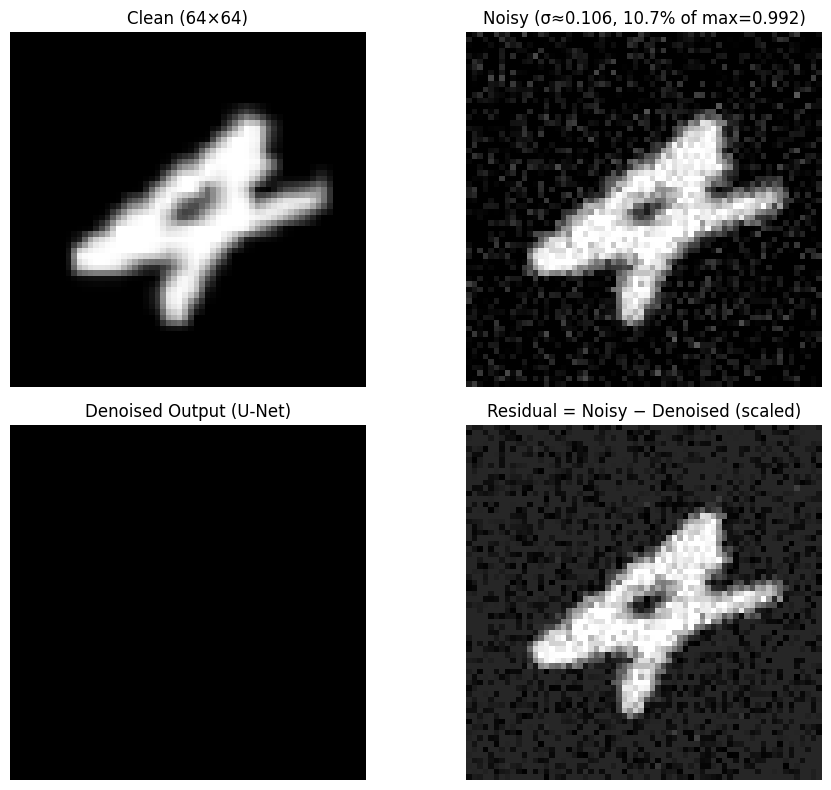

In [57]:
import torch, random, math
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- load model from saved checkpoint (epoch 1) ---
ckpt_path = "unet_epoch_010.pth"
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from {ckpt_path}")

# --- pick one random test image ---
test_ds = loaders['test'].dataset
idx = random.randrange(len(test_ds))
clean_28, _ = test_ds[idx]   # shape: (1, 28, 28), values in [0,1]

# --- resize to 64x64 for the U-Net ---
clean = F.interpolate(clean_28.unsqueeze(0), size=(64, 64),
                      mode="bilinear", align_corners=False)  # [1,1,64,64]
clean = clean.detach().cpu()

# --- add random Gaussian noise (10–30% of image max) ---
max_val = clean.view(1, -1).max(dim=1, keepdim=True)[0].view(1,1,1,1).clamp_min(1e-8)
frac = torch.rand(1,1,1,1) * (0.30 - 0.10) + 0.10  # random in [0.10, 0.30]
sigma = frac * max_val
noisy = (clean + torch.randn_like(clean) * sigma).clamp(0.0, 1.0)
noisy = noisy.detach().cpu()

# --- denoise using the trained model ---
model.eval()
with torch.no_grad():
    pred = model(noisy.to(device)).detach().cpu()

# --- compute residual (difference) and scale for visualization ---
residual = torch.abs(noisy - pred)
res_vis = (residual - residual.min()) / (residual.max() - residual.min() + 1e-8)
residual, res_vis = residual.detach().cpu(), res_vis.detach().cpu()

# --- prepare values for display ---
noise_pct = float(frac.item() * 100.0)
sig_val = float(sigma.item())
max_v = float(max_val.item())

# --- plot all images side by side ---
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(clean.squeeze(), cmap='gray')
plt.title("Clean (64×64)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(noisy.squeeze(), cmap='gray')
plt.title(f"Noisy (σ≈{sig_val:.3f}, {noise_pct:.1f}% of max={max_v:.3f})")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(pred.squeeze(), cmap='gray')
plt.title("Denoised Output (U-Net)")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(res_vis.squeeze(), cmap='gray')
plt.title("Residual = Noisy − Denoised (scaled)")
plt.axis('off')

plt.tight_layout()
plt.show()
